# *Computing the PFSS model*
***

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import astropy
import astropy.units as u

In [3]:
import pysmsh
import cider

In [4]:
RSun = astropy.constants.R_sun

### Load magnetogram & process

Load a HMI synchronic pole-filled magnetogram (available from JSOC)

In [5]:
import cider.magnetogram
import cider.magnetogram.hmi

In [6]:
magnetogram_file = "../data/hmi.mrdailysynframe_polfil_720s.20211009_120000_TAI.Mr_polfil.fits"

In [7]:
raw_magnetogram = cider.magnetogram.hmi.read_hmi_daily_synframe(magnetogram_file)

Remap to a uniform lon-lat grid which is required by the PFSS solver

In [8]:
import cider.utils.map

In [9]:
# Create an empty map with the requested resolution
uniform_map \
    = cider.utils.map.create_full_sun_plate_carree_map(raw_magnetogram,
                                                       deg_per_pixel=1.0,
                                                       frame=raw_magnetogram.coordinate_frame.name)

In [10]:
remapped_magnetogram = cider.magnetogram.regrid_to_grid_of_map(raw_magnetogram, uniform_map)

Balance the magnetogram

In [11]:
balanced_magnetogram = cider.magnetogram.Balance.multiplicative(remapped_magnetogram)

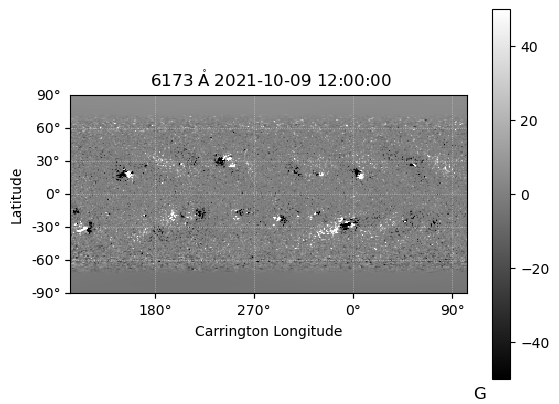

In [12]:
balanced_magnetogram.peek(vmin=-50, vmax=50, norm=None)

Compute flux content

In [13]:
cider.magnetogram.Flux.compute(remapped_magnetogram)

FluxContent(signed=<Quantity -4.74894095e+15 m2 G>, unsigned=<Quantity 2.93162172e+19 m2 G>, area=<Quantity 6.0821044e+18 m2>)

In [14]:
cider.magnetogram.Flux.compute(balanced_magnetogram)

FluxContent(signed=<Quantity 63037.40429688 m2 G>, unsigned=<Quantity 2.93162172e+19 m2 G>, area=<Quantity 6.0821044e+18 m2>)

### Compute the PFSS model

In [15]:
import cider.models.pfss

Specify the radial grid coordinates. For the PFSS model, the outer radius defines the source surface

In [16]:
r = np.linspace(1.0, 2.5, 256)*RSun

In [17]:
# Instantiate the model
pfss = cider.models.pfss.PotentialFieldSourceSurfaceModel(balanced_magnetogram, r)

In [18]:
# Compute the solution
pfss.compute()

In [19]:
# Compute the magnetic field
magnetic_field = pfss.magnetic_field()

Output the cell-centered magnetic field components for external visualization

In [24]:
import pyevtk.hl as evtk

In [26]:
B = magnetic_field

evtk.gridToVTK("pfss_example",
               B.mesh.edges.r/RSun.si.value,
               B.mesh.edges.clt,
               B.mesh.edges.lon,
               cellData={"Br" : 0.5*(B.data[0][1::, :, :] + B.data[0][0:-1, :, :]),
                         "Bt" : 0.5*(B.data[1][:, 1::, :] + B.data[1][:, 0:-1, :]),
                         "Bp" : 0.5*(B.data[2][:, :, 1::] + B.data[2][:, :, 0:-1])}
              )

'/Users/jpomoell/cider/notebooks/pfss.vtr'

***